In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
#from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge

from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error
from modelling_functions import *

## Processing for Models

In [39]:
#### Read Data files
dict_dictonary = {}
housing, housing_features, feat_labels = read_and_clean(filepath = "../data/clean_train.csv")

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice']


In [40]:
htest_id, htest_features, htest_labels = read_and_clean(filepath = "../data/clean_test.csv", test = True)

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'PoolArea']


In [41]:
training = housing_features
testing = htest_features

In [45]:
print(training.shape)
print(testing.shape)
housing.saleprice[1:2]

(1452, 214)
(1459, 214)


1    12.109011
Name: saleprice, dtype: float64

In [43]:
test_col = testing.columns
train_col = training.columns

missing = [x for x in train_col if x not in test_col]
needed = [ x for x in test_col if x not in train_col]


In [44]:
training = training.drop(missing, axis=1)
testing = testing.drop(needed, axis=1)

In [54]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.2)

## Lasso

C:\Users\Olympus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


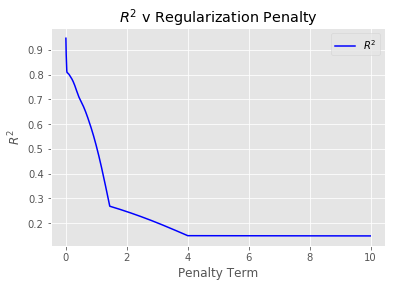

In [10]:
alp = optimize_penalty(htrain, ptrain, model=Lasso, min_=1e-4, max_=10, step=0.0001, plot=True)

In [59]:
lasso = Lasso(normalize=False)
lasso.set_params(alpha = 3e-4)
lasso.fit(htrain, ptrain)

print(lasso.score(htrain, ptrain))
print(lasso.score(htest, ptest))
#print(selected_coefs)
pred_lasso = lasso.predict(htest)
mean_squared_error(pred_lasso, ptest)

0.9354821330769229
0.9374772854127659


0.008878141590748697

In [60]:
pred = np.exp(lasso.predict(testing))

In [61]:
Submission(htest_id, pred, "lasso.csv")

In [48]:
drop_col = list(training.columns[np.where(lasso.coef_ == 0)[0]])
print(drop_col)

['x1stflrsf', 'mssubclass_150', 'mssubclass_180', 'mssubclass_190', 'mssubclass_40', 'mssubclass_45', 'mssubclass_50', 'mssubclass_80', 'mssubclass_85', 'mssubclass_90', 'street_grvl', 'street_pave', 'lotshape_irg', 'lotshape_reg', 'landcontour_bnk', 'landcontour_low', 'utilities_allpub', 'landslope_gtl', 'landslope_othr', 'neighborhood_med_low', 'neighborhood_true_med', 'condition2_artery', 'condition2_feedr', 'condition2_norm', 'condition2_posa', 'bldgtype_fmcon', 'housestyle_1.5unf', 'housestyle_high', 'housestyle_low', 'housestyle_med', 'overallcond_6', 'roofstyle_high', 'roofstyle_med', 'roofmatl_high', 'roofmatl_med', 'exterior1st_cemntbd', 'exterior1st_high', 'exterior1st_highest', 'exterior1st_vinylsd', 'exterior2nd_high', 'exterior2nd_highest', 'exterior2nd_low', 'exterior2nd_lowest', 'masvnrtype_brkface', 'masvnrtype_none', 'exterqual_fa', 'exterqual_gd', 'extercond_gd', 'extercond_po', 'foundation_brktil', 'foundation_other', 'foundation_slab', 'bsmtqual_none', 'bsmtqual_ta'

In [49]:
training = training.drop(drop_col, axis = 1)
testing = testing.drop(drop_col, axis = 1)

In [50]:
print(training.shape)
print(testing.shape)

(1452, 105)
(1459, 105)


In [176]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.33, random_state = 480)

## RandomForestRegressor

In [62]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [15, 20, 30, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [16, 32, 64]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 1288, 2377, 3466, 4555, 5644, 6733, 7822, 8911, 10000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 29, 48, 67, 86, 105, 124, 143, 162, 181, 200, None], 'min_samples_split': [15, 20, 30, 40], 'min_samples_leaf': [16, 32, 64], 'bootstrap': [True, False]}


In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(htrain, ptrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 1288, 2377, 3466, 4555, 5644, 6733, 7822, 8911, 10000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 29, 48, 67, 86, 105, 124, 143, 162, 181, 200, None], 'min_samples_split': [15, 20, 30, 40], 'min_samples_leaf': [16, 32, 64], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [64]:
rf_random.best_params_

{'n_estimators': 10000,
 'min_samples_split': 30,
 'min_samples_leaf': 16,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [65]:
#rf_random.fit(htrain, ptrain)

print(rf_random.score(htrain, ptrain))
pred_rf_random = rf_random.predict(htest)
mean_squared_error(pred_rf_random, ptest)

0.887674761441383


0.017456483476221765

In [99]:
clf = RandomForestRegressor(n_estimators=10000, 
                            random_state=9, 
                            n_jobs=-1, 
                            min_samples_split = 40, 
                            min_samples_leaf = 1, 
                            max_features = 'sqrt', 
                            max_depth = 162,
                            bootstrap = True)
#sfm = SelectFromModel(clf, threshold = 0.01)
#sfm.fit(htrain, ptrain)
# ## Not Finished
# # Measure Feature Importance
#feature_selected = []
#for feature_list_index in sfm.get_support(indices=True):
#     feature_selected.append(feat_labels[feature_list_index])
#proxy = feature_selected
#trimmed = ['x1stflrsf', 'x2ndflrsf', 'garagecars', 'overallcond', 'saleprice', 'Unnamed: 0', 'bsmtfinsf1']
#testing = testing[proxy]
#housing_features = housing_features[trimmed_features]
#print(feature_selected)

In [100]:
clf.fit(htrain, ptrain)

clf.score(htest, ptest)

0.8681023535227521

In [101]:
pred_clf = clf.predict(htest)
mean_squared_error(pred_clf, ptest)

0.021323342699261186

## ElasticNet

In [66]:
regr = ElasticNetCV(l1_ratio = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .99, 1], 
                    cv = 5, 
                    n_jobs = -1,
                    normalize = True,
                    verbose = 0)

In [67]:
regr.fit(htrain, ptrain)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
       max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [68]:
regr.score(htest, ptest)
pred_regr = regr.predict(htest)
mean_squared_error(pred_regr, ptest)

0.008789572920294558

In [69]:
regr.l1_ratio_

0.8

NameError: name 'pred' is not defined

### Ridge

In [70]:
ridge = RidgeCV(normalize = True, cv = 5)

ridge.fit(htrain, ptrain)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring=None, store_cv_values=False)

In [71]:
print(ridge.score(htest, ptest))
pred_ridge = ridge.predict(htest)
mean_squared_error(pred_ridge, ptest)

0.9355387978049011


0.00915340423038542

In [116]:
t = pd.read_csv('submission_13703.csv')

In [72]:
lm = LinearRegression(normalize = True)
lm.fit(htrain, ptrain)
print(lm.score(htest, ptest))
pred_linear = lm.predict(htest)
mean_squared_error(pred_linear, ptest)

0.9357587764246782


0.009122167561500956

In [107]:
a = 0.1
b = 0.3
c = 0.5
d = 0.1

pred_ridge_sub = ridge.predict(testing)
pred_lasso_sub = lasso.predict(testing)
pred_linear_sub = lm.predict(testing)
pred_regr_sub = regr.predict(testing)
#pred_rf_random_sub = rf_random.predict(testing)

pred_sum = np.exp(a*(pred_ridge_sub) + b*(pred_lasso_sub) + c*(pred_regr_sub) + d*(pred_linear_sub))

Submission(htest_id, pred_sum, "stacked_submission.csv")

In [59]:
ridge.predict(testing)

array([11.64867337, 12.03696324, 12.08524366, ..., 12.07376596,
       11.69232003, 12.34172877])

In [121]:
pred_sum.shape

(1459,)

In [105]:
a = 0.1
b = 0.3
c = 0.5
d = 0.1



pred_sum = a*(pred_ridge) + b*(pred_lasso) + c*(pred_regr) + d*(pred_linear)
mean_squared_error(pred_sum, ptest)

0.008787941988549756

In [99]:
pred_sum = (pred_ridge + pred_lasso + pred_regr + pred_linear)/4
mean_squared_error(pred_sum, ptest)

0.008833554363229298

In [76]:
mean_squared_error(pred_sum, ptest)

0.008831879607369957

## Kernal Ridge

In [167]:
from sklearn.kernel_ridge import KernelRidge

ker = KernelRidge(alpha = 40)
ker.fit(htrain, ptrain)

KernelRidge(alpha=40, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

In [168]:
print(ker.score(htest, ptest))
pred_ker = ker.predict(htest)
mean_squared_error(pred_ker, ptest)

0.9104599880113221


0.014475560496523989

## Linear Model

In [140]:
lm = LinearRegression(normalize = True, n_jobs = -1)

In [141]:
training = housing_features.drop(housing_features.columns[drop_col], axis=1)
testing = htest_features.drop(housing_features.columns[drop_col], axis=1)

In [142]:
print(training.shape)
print(testing.shape)

(1455, 48)
(1459, 48)


In [143]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.33, random_state = 0)

In [144]:
lm.fit(htrain, ptrain)

lm.score(htest, ptest)

0.9051018423596444

In [100]:
lm.sample_

AttributeError: 'LinearRegression' object has no attribute 'sample_'

In [145]:
pred = lm.predict(htest)
mean_squared_error(pred, ptest)

0.0151557569514424

In [146]:
pred = np.exp(lm.predict(testing))
print(pred[1:3])
Submission(htest_id, pred)

[158204.65351117 173280.29005707]
